# Dataset analysis
Understanding the data is essential part of creating models that perform well. We can understand data through data analysis.

In [47]:
import keras_tuner as kt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf

In [48]:
df = pd.read_csv('dataset.csv')
df.head()

,PM10 Concentration,PM10 Unit,DatetimeBegin,DatetimeEnd,PM2.5 Concentration,PM2.5 Unit,CO Concentration,CO Unit,NO2 Concentration,NO2 Unit,SO2 Concentration,SO2 Unit,C6H6 Concentration,C6H6 Unit
0,38.942,µg/m3,2018-01-01 00:00:00 +01:00,2018-01-01 01:00:00 +01:00,46.409,µg/m3,0.46168,mg/m3,21.6056,µg/m3,5.36549,µg/m3,1.10825,µg/m3
1,52.889,µg/m3,2018-01-01 01:00:00 +01:00,2018-01-01 02:00:00 +01:00,53.467,µg/m3,0.43268,mg/m3,21.1869,µg/m3,NaN,NaN,0.93600,µg/m3
2,37.007,µg/m3,2018-01-01 02:00:00 +01:00,2018-01-01 03:00:00 +01:00,37.668,µg/m3,0.39208,mg/m3,16.2845,µg/m3,5.14364,µg/m3,0.69225,µg/m3
3,35.837,µg/m3,2018-01-01 03:00:00 +01:00,2018-01-01 04:00:00 +01:00,37.333,µg/m3,0.38628,mg/m3,17.3246,µg/m3,5.16466,µg/m3,0.59800,µg/m3
4,34.408,µg/m3,2018-01-01 04:00:00 +01:00,2018-01-01 05:00:00 +01:00,29.130,µg/m3,0.36308,mg/m3,15.5656,µg/m3,5.23302,µg/m3,0.57200,µg/m3


In [49]:
print(f'Number of rows: {len(df)}')

Number of rows: 26305


In [50]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM10 Concentration,25956.0,22.392300,14.358808,0.002600,12.415750,19.768500,28.975500,353.12000
PM2.5 Concentration,25728.0,14.541749,12.478324,0.012200,5.852625,10.847500,19.669000,118.52000
CO Concentration,25640.0,0.384108,0.165666,0.041760,0.265060,0.344636,0.467016,3.29904
NO2 Concentration,25650.0,31.520344,20.845578,1.100930,15.093450,27.236400,43.630850,145.59900
SO2 Concentration,25155.0,4.601444,9.877013,-3.835720,0.875406,3.309310,7.006040,657.84500
C6H6 Concentration,25727.0,1.008329,1.376376,0.000975,0.331500,0.674375,1.496950,109.64200


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >], dtype=object)

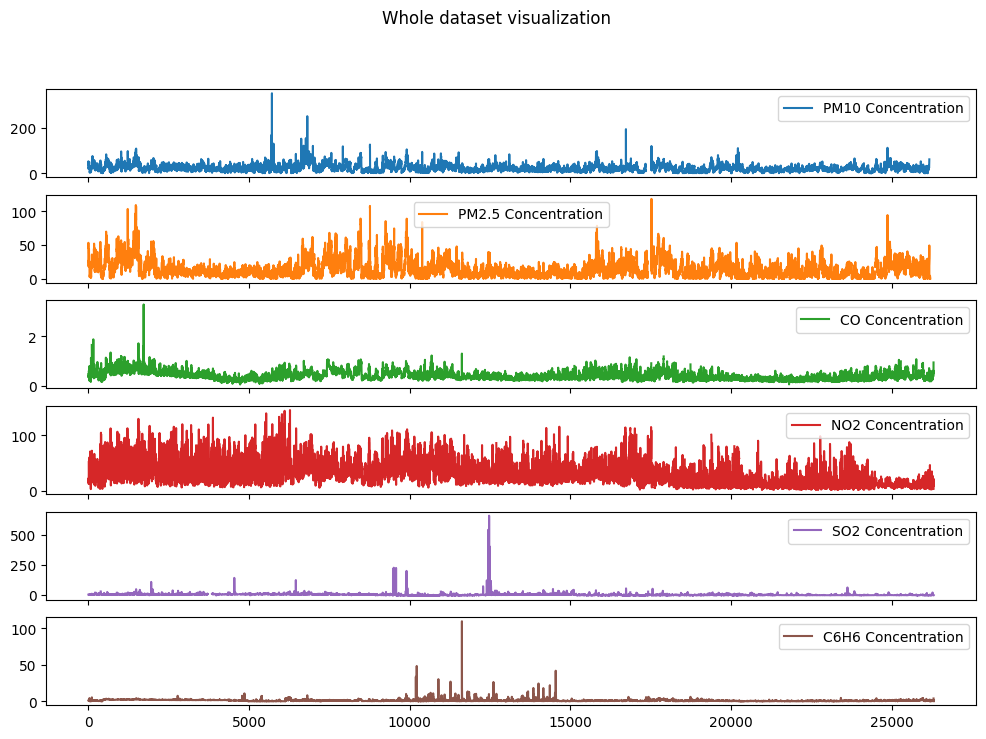

In [51]:
df.plot(subplots=True, title='Whole dataset visualization')

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >], dtype=object)

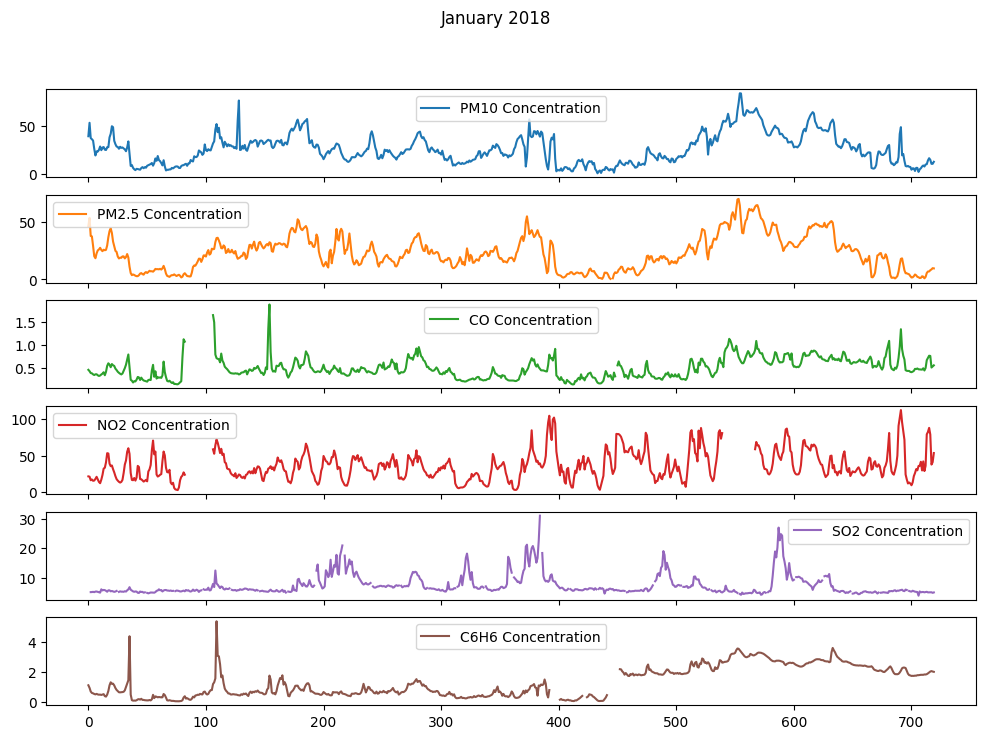

In [52]:
df[:720].plot(subplots=True, title='January 2018')

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >], dtype=object)

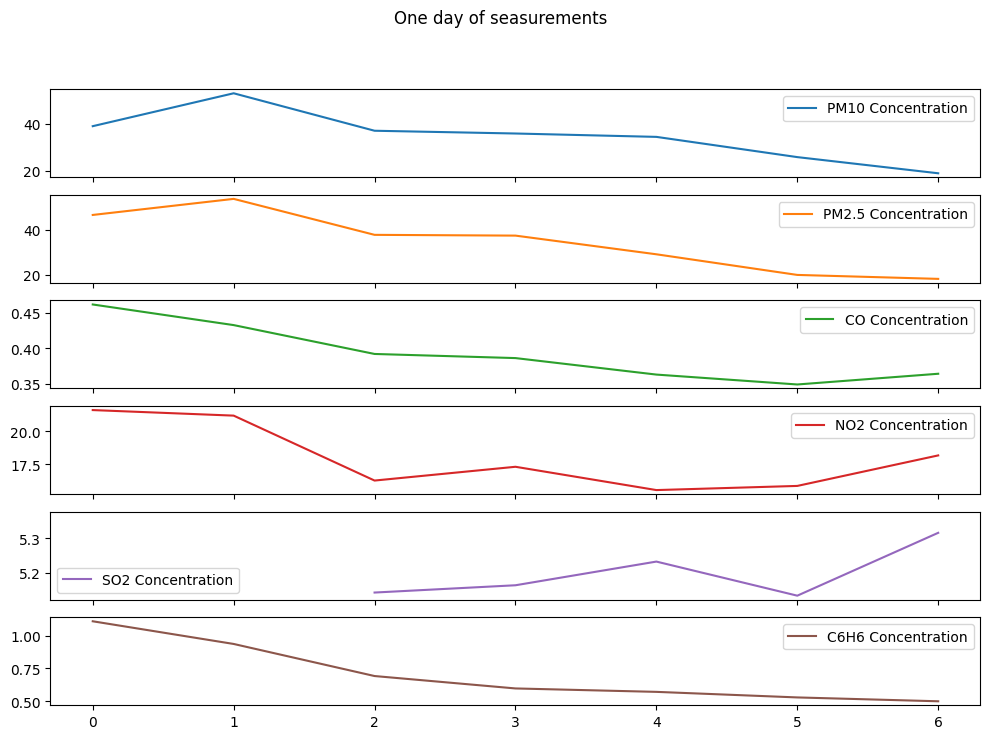

In [53]:
df[:7].plot(subplots=True, title='One day of seasurements')

c:\Users\Gamebox\Desktop\School\FIIT\BP_time_series_forecasting_cambals\BP_env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

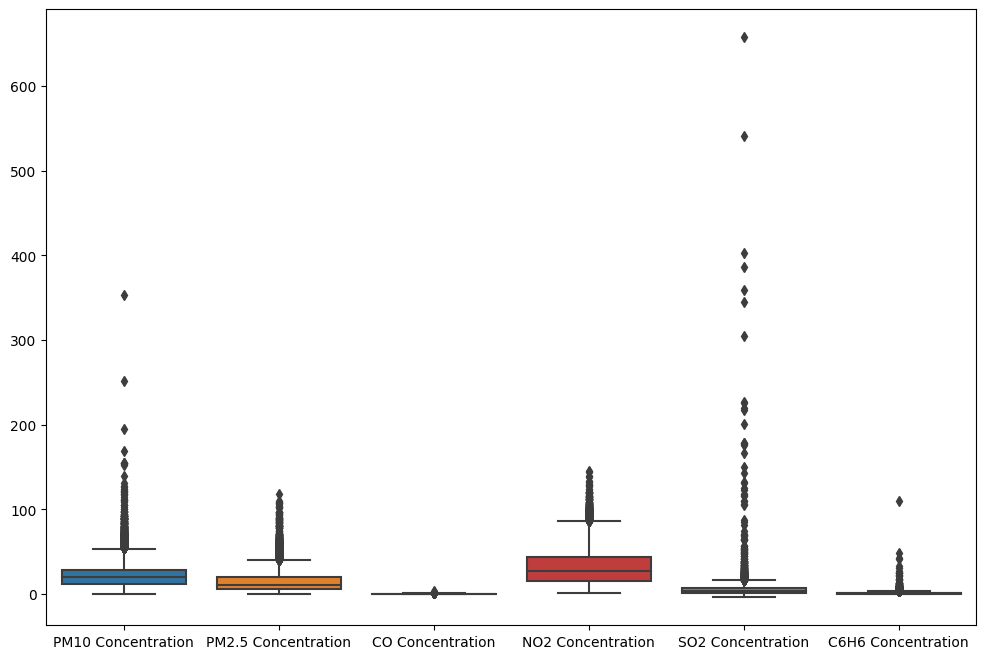

In [54]:
sns.boxplot(data=df)

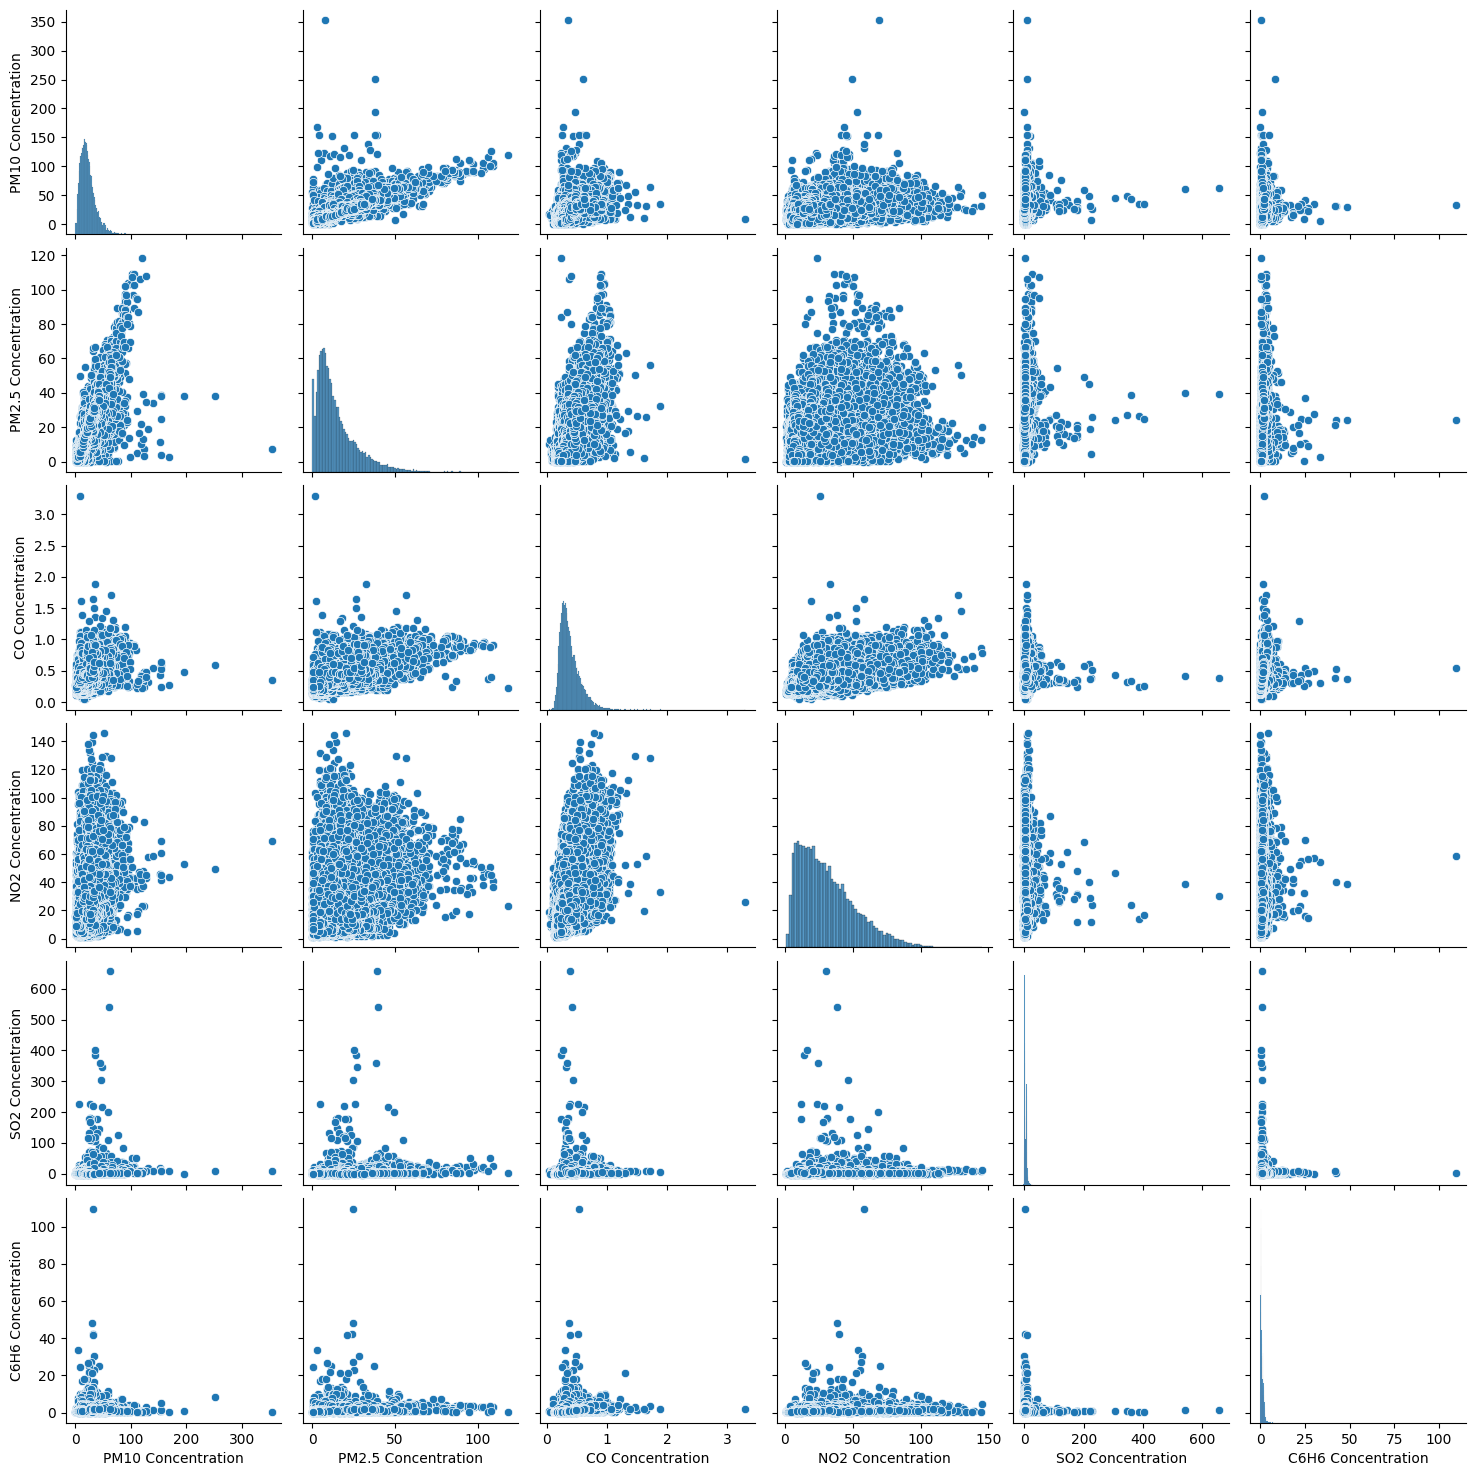

In [55]:
sns.pairplot(data=df)

In [56]:
df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']].corr(method='pearson')

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration,SO2 Concentration,C6H6 Concentration
PM10 Concentration,1.000000,0.791429,0.517186,0.340900,0.173231,0.252359
PM2.5 Concentration,0.791429,1.000000,0.614492,0.238039,0.124964,0.269209
CO Concentration,0.517186,0.614492,1.000000,0.602560,0.096733,0.377680
NO2 Concentration,0.340900,0.238039,0.602560,1.000000,0.134214,0.247135
SO2 Concentration,0.173231,0.124964,0.096733,0.134214,1.000000,0.073409
C6H6 Concentration,0.252359,0.269209,0.377680,0.247135,0.073409,1.000000


<AxesSubplot: >

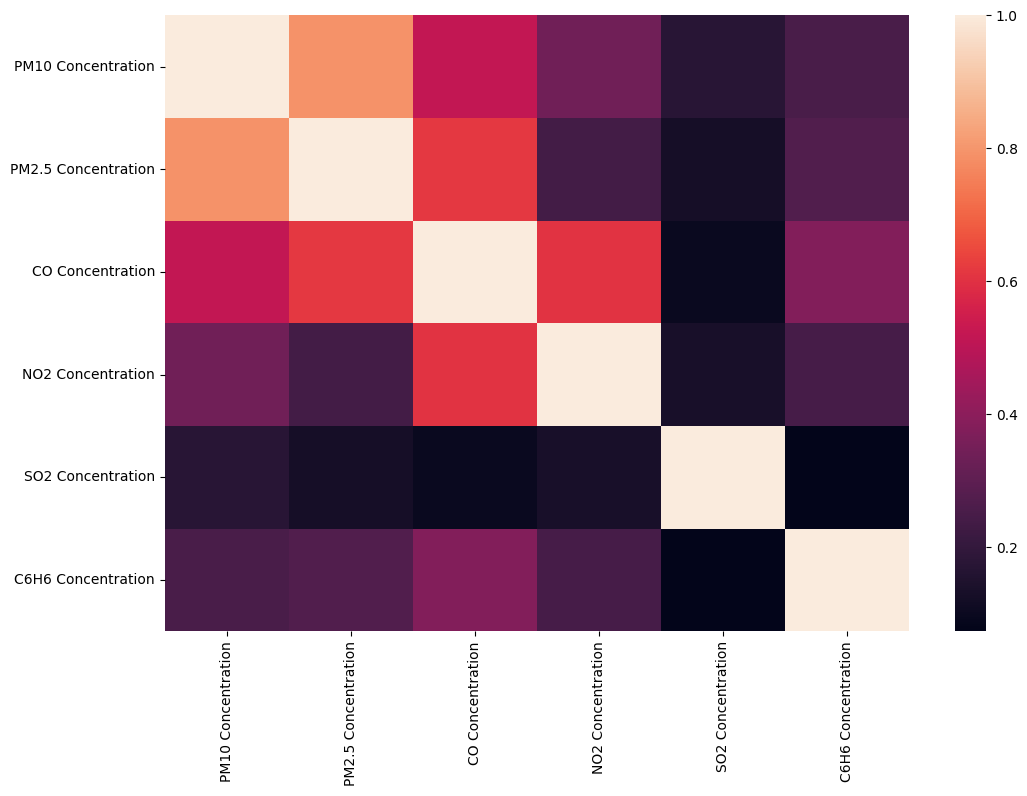

In [57]:
sns.heatmap(data=df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']].corr(method='pearson'))

The table shows that correlation coefficient between any pair of measured data is considerably strong. This means our data is related. We can see particularly strong correlation between PM10 and PM2.5 particles and PM2.5 particles and CO concentration.

In [58]:
nan_rows = sum(df.apply(lambda x: sum(x.isnull().values), axis = 1) > 0)
print(f'Number of rows containing NaN is {nan_rows}/{len(df)} or {round(nan_rows / len(df) * 100, 3)} %')

Number of rows containing NaN is 3052/26305 or 11.602 %


# Data cleaning

#### Time-series cleaning

In [59]:
def timeCleaning(x):
    return x.rsplit(' ', 1)[0]
df['DatetimeBegin'] = df['DatetimeBegin'].apply(timeCleaning)
df.drop(columns='DatetimeEnd', inplace=True)

#### NaN imputing

In [60]:
df.drop(['PM10 Unit', 'PM2.5 Unit', 'CO Unit', 'NO2 Unit', 'SO2 Unit', 'C6H6 Unit'], inplace=True, axis=1)
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']])
df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']] = imputer.transform(df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']])
df

,PM10 Concentration,DatetimeBegin,PM2.5 Concentration,CO Concentration,NO2 Concentration,SO2 Concentration,C6H6 Concentration
0,38.942000,2018-01-01 00:00:00,46.409000,0.461680,21.605600,5.365490,1.108250
1,52.889000,2018-01-01 01:00:00,53.467000,0.432680,21.186900,7.363020,0.936000
2,37.007000,2018-01-01 02:00:00,37.668000,0.392080,16.284500,5.143640,0.692250
3,35.837000,2018-01-01 03:00:00,37.333000,0.386280,17.324600,5.164660,0.598000
4,34.408000,2018-01-01 04:00:00,29.130000,0.363080,15.565600,5.233020,0.572000
...,...,...,...,...,...,...,...
26300,20.642903,2020-10-19 15:00:00,13.122164,0.361663,29.192009,0.637868,0.628225
26301,21.812805,2020-10-20 17:00:00,14.244807,0.383440,30.921196,0.841092,1.125800
26302,21.234059,2020-03-29 22:00:00,13.375752,0.361133,29.743226,4.367483,0.516425
26303,22.205407,2020-05-15 12:00:00,14.307335,0.379205,31.180601,4.568202,0.929500


In [61]:
df_timestamps = pd.to_datetime(df.pop('DatetimeBegin'), format='%Y.%m.%d %H:%M:%S')

#### Outlier imputation

c:\Users\Gamebox\Desktop\School\FIIT\BP_time_series_forecasting_cambals\BP_env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

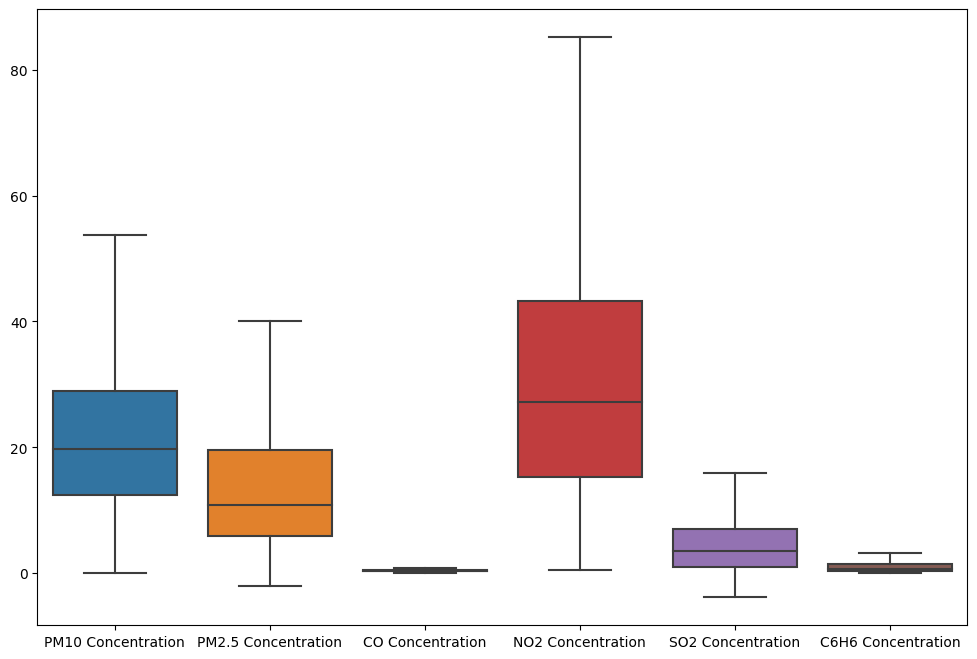

In [62]:
class QuantileOutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def impute(self, data, feature: str):
        # print(f'Imputing outliers for feature: {feature}')
        q25, q75 = np.percentile(data[feature], 25), np.percentile(data[feature], 75)
        iqr = q75 - q25
        # print(f'q25 = {round(q25, 3)}; q75 = {round(q75, 3)}; IQR = {round(iqr, 3)}')
        cutoff = round(iqr * 1.5, 5)
        lower, upper = q25 - cutoff, q75 + cutoff
        # print('cutoff=', round(cutoff, 3), 'lower=', round(lower, 3), 'upper=', round(upper, 3), '\n')
        q5, q95 = np.percentile(data[feature], 5), np.percentile(data[feature], 95)

        outliers_lower = data[feature] <= lower
        data[feature].mask(outliers_lower, other=q5, axis=0, inplace=True)
        outliers_upper = data[feature] >= upper
        data[feature].mask(outliers_upper, other=q95, axis=0, inplace=True)
        return data

    def fit(self, X, y=None):
        self.data = X
        self.features = [x for x in df.columns if x not in ['longitude', 'latitude', 'TEMP', 'PRES', 'warning']]
        return self

    def transform(self, X, y=None):
        cols = [x for x in df.columns if x not in ['longitude', 'latitude', 'TEMP', 'PRES', 'warning']]
        for feature in cols:
            self.data = self.impute(self.data, feature)
        return self.data

outlier_imputer = QuantileOutlierImputer()
df = outlier_imputer.fit_transform(df)
sns.boxplot(data=df)

## Augmented Dickey-Fuller (ADF) unit root test
Augmented Dickey-Fuller (ADF) unit root test is defined as follows:
- $H_0$: the data possesses a unit root (random walk) and it is non-stationary.
- $H_a$: the data is stationary.

Result intepretation:
- if ADF statistic test < 1% 5% 10% (Critical Values) then $H_0$ is rejected
- if P-Value < 0.05 then $H_0$ is rejected 

In [63]:
cols_selected = []
for col in df.columns:
    missing = df[col].isnull().sum()
    if not missing:
        dftest = adfuller(df[col], autolag = 'AIC')
        if (dftest[1] < 0.05) and (dftest[2] > 3):
            cols_selected.append(col)
            print(col, '  ADF val: ', dftest[0], '\tp-value: ', dftest[1], '\tNum of lags: ', dftest[2])

PM10 Concentration   ADF val:  -13.112281980157404 	p-value:  1.6255791729309529e-24 	Num of lags:  48
PM2.5 Concentration   ADF val:  -11.312823687566896 	p-value:  1.2270193600409791e-20 	Num of lags:  49
CO Concentration   ADF val:  -9.160084881991539 	p-value:  2.5469464851964914e-15 	Num of lags:  49
NO2 Concentration   ADF val:  -9.987045131884857 	p-value:  2.0424049284332727e-17 	Num of lags:  49
SO2 Concentration   ADF val:  -5.466409384646881 	p-value:  2.453219113355593e-06 	Num of lags:  49
C6H6 Concentration   ADF val:  -8.239670355957323 	p-value:  5.762446520887207e-13 	Num of lags:  49


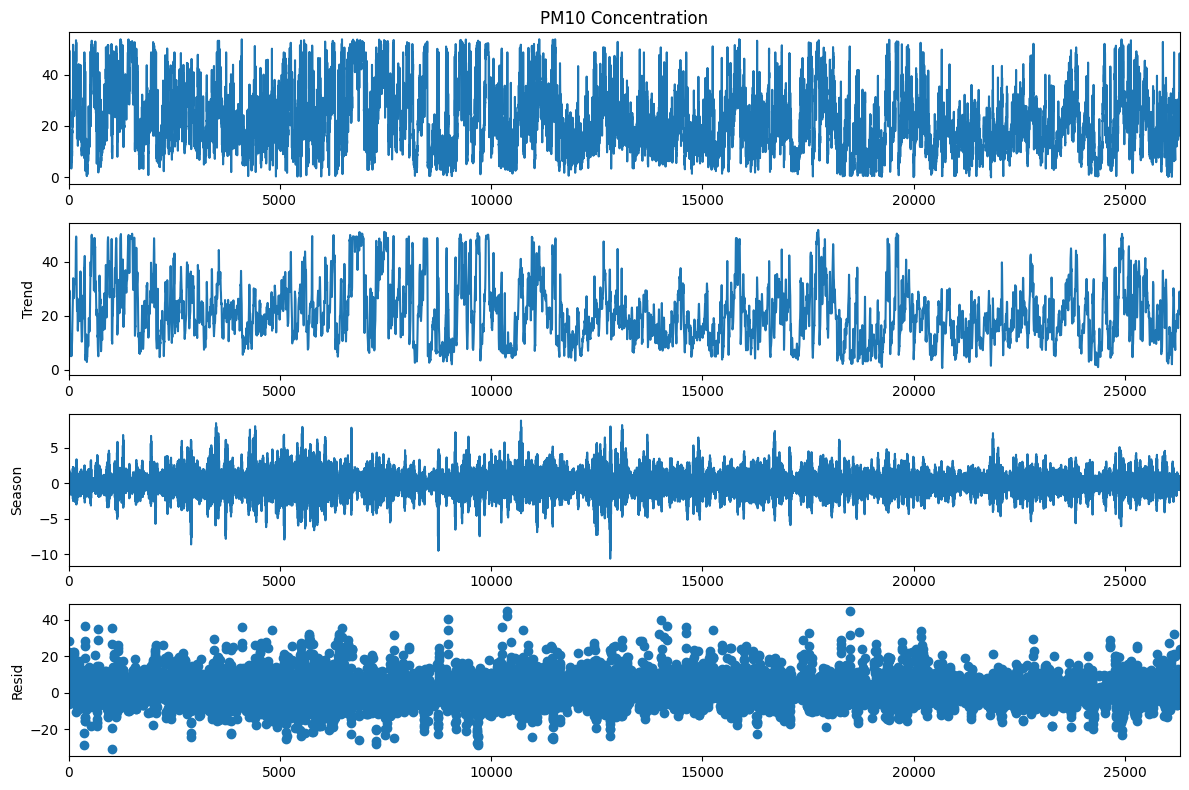

In [64]:
result_pm10 = STL(df['PM10 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_pm10.plot()
plt.show()
# data_cleaned = result.trend.reshape(-1, 1)

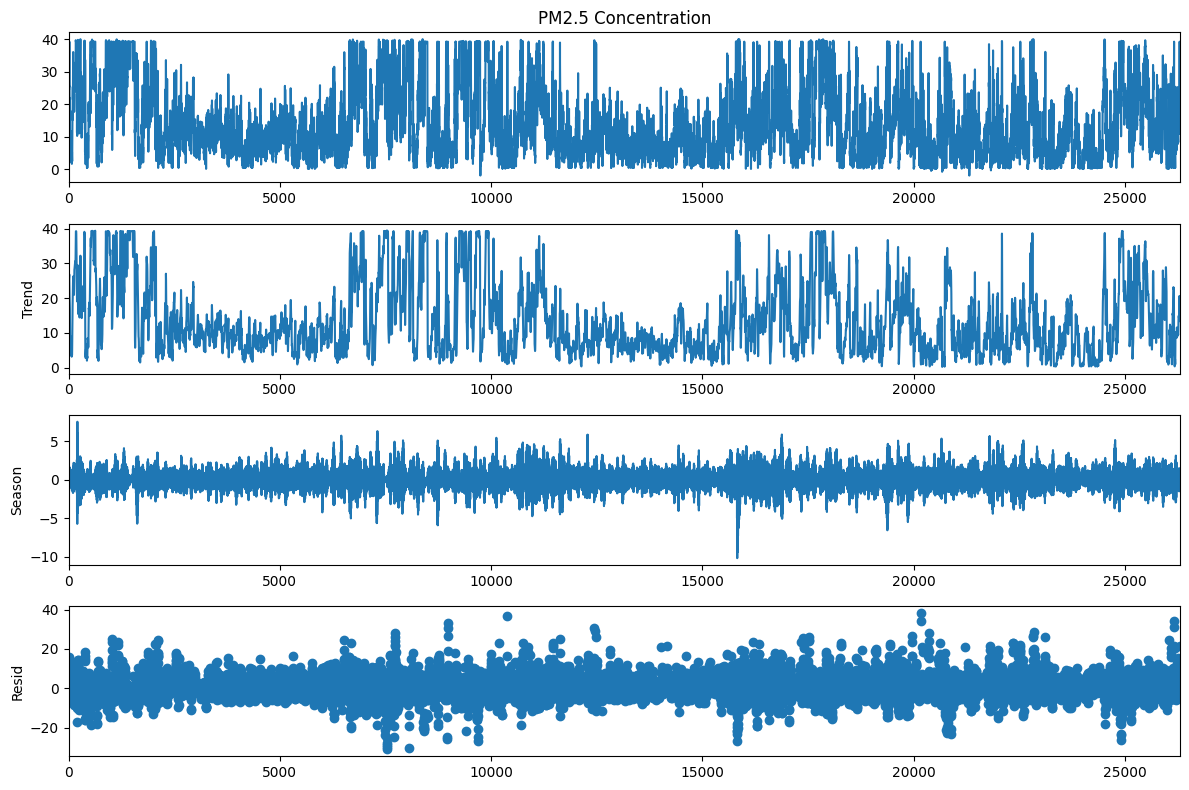

In [65]:
result_pm25 = STL(df['PM2.5 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_pm25.plot()
plt.show()

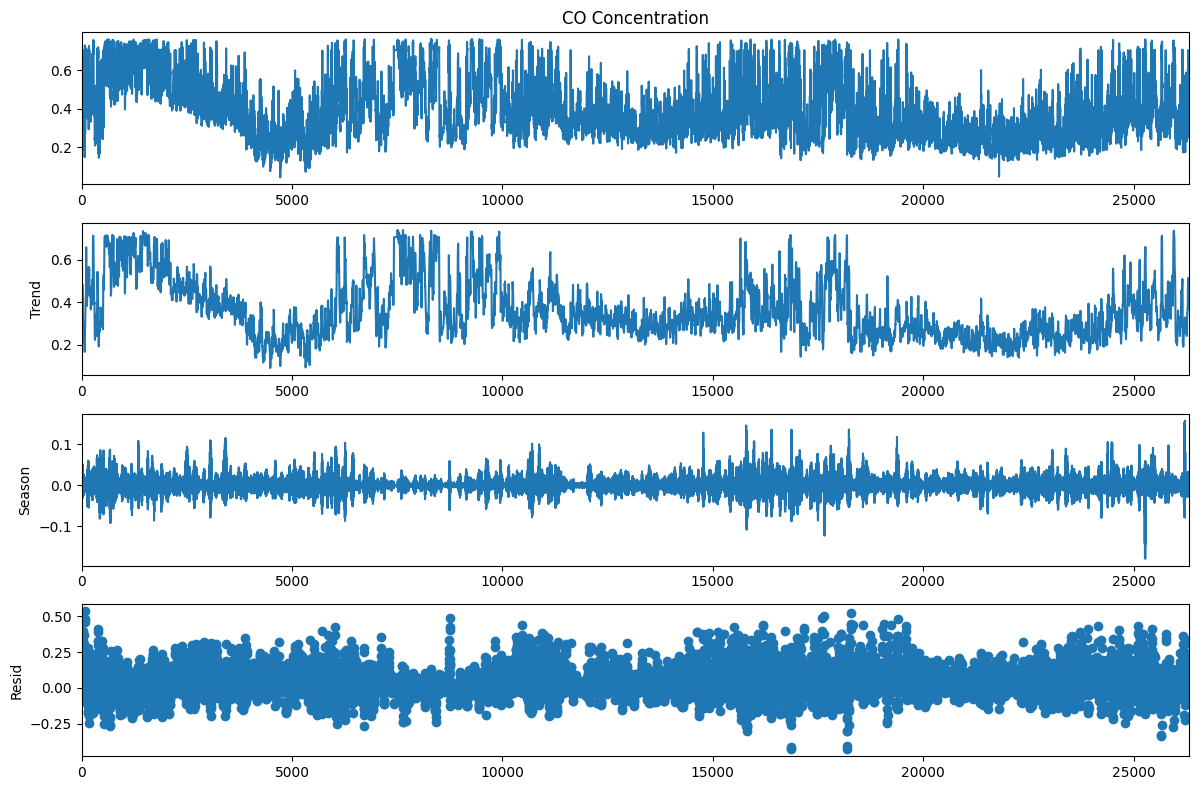

In [66]:
result_co = STL(df['CO Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_co.plot()
plt.show()

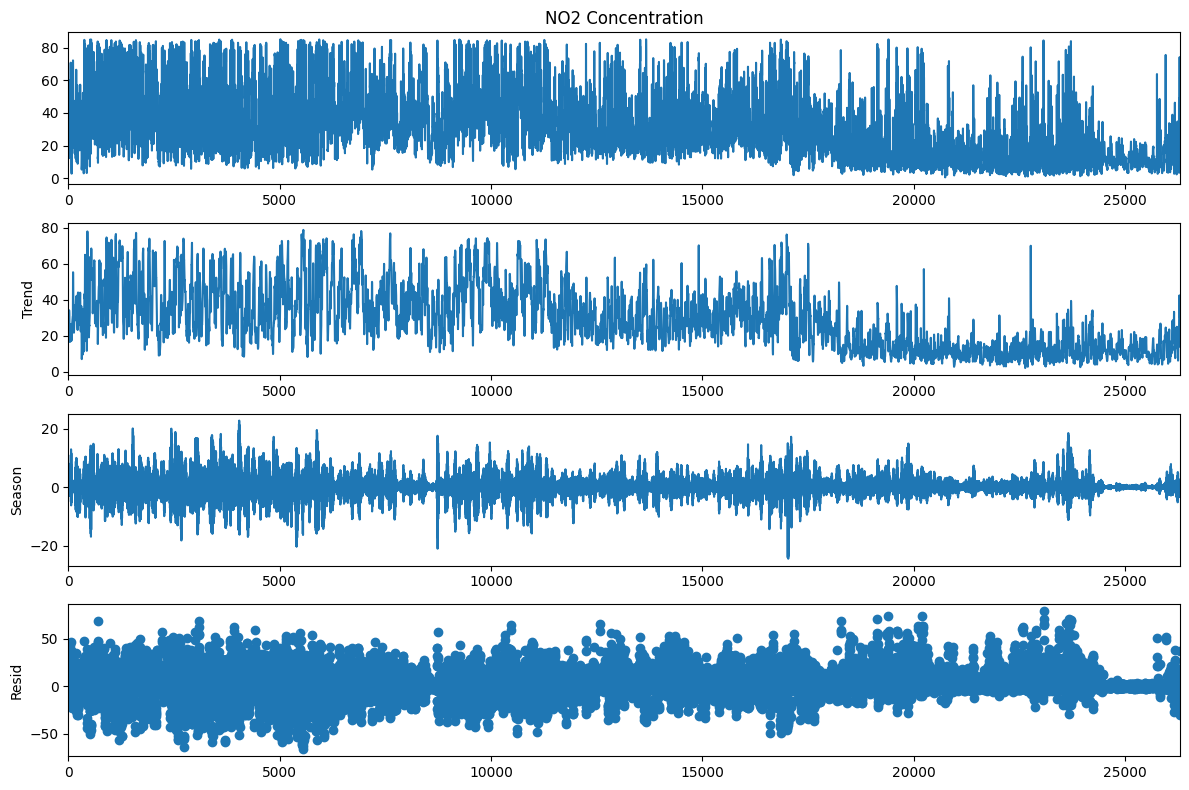

In [67]:
result_no2 = STL(df['NO2 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_no2.plot()
plt.show()

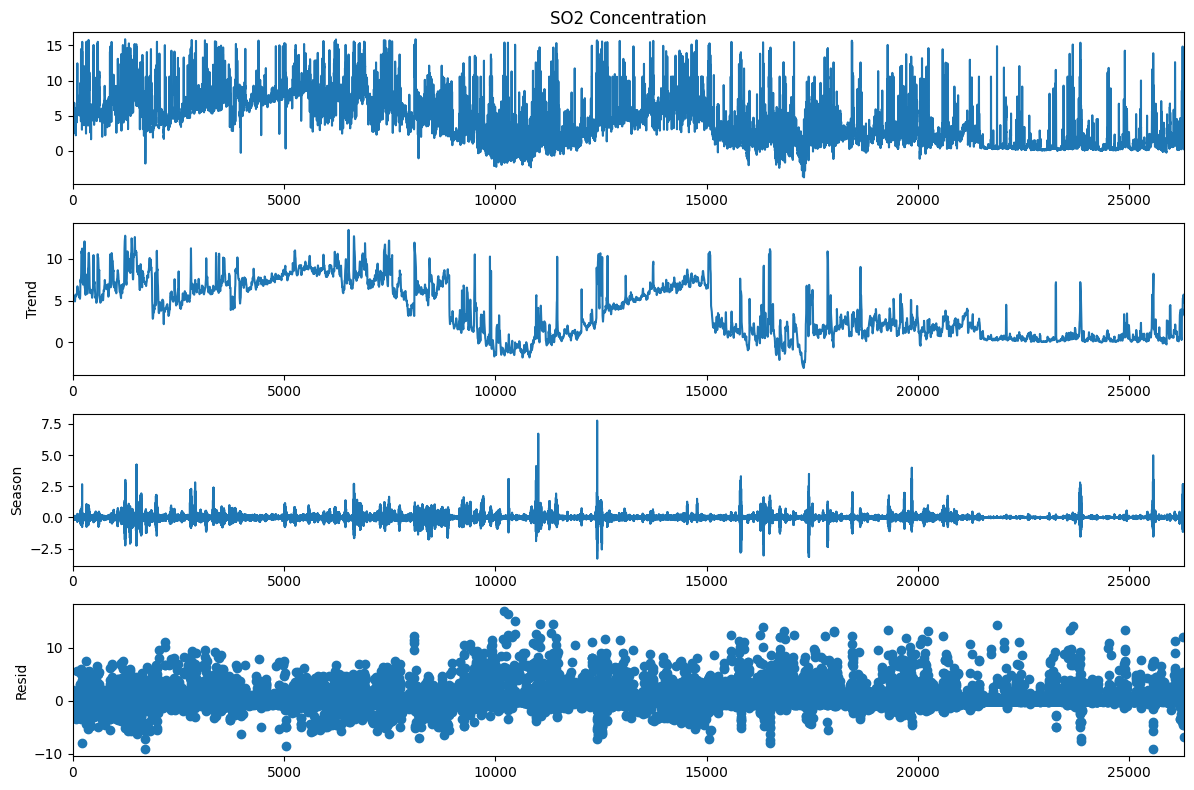

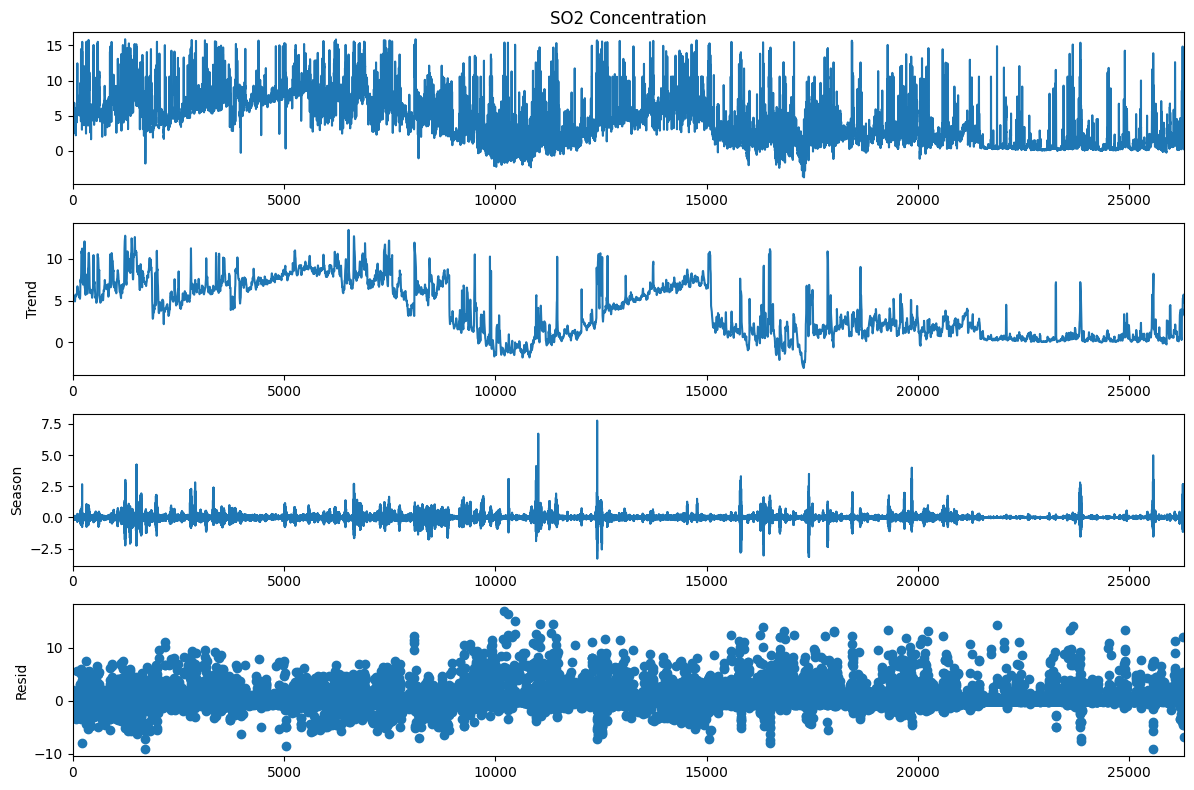

In [68]:
result_so2 = STL(df['SO2 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_so2.plot()
# plt.show()

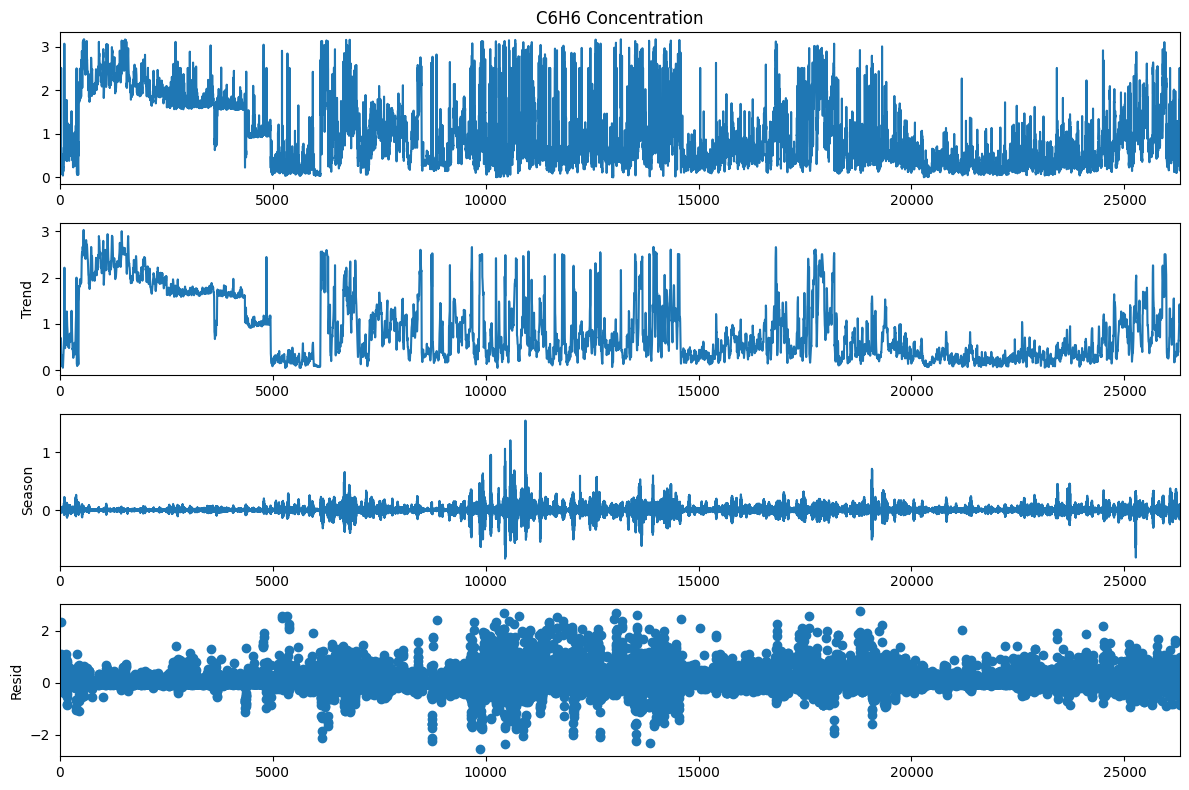

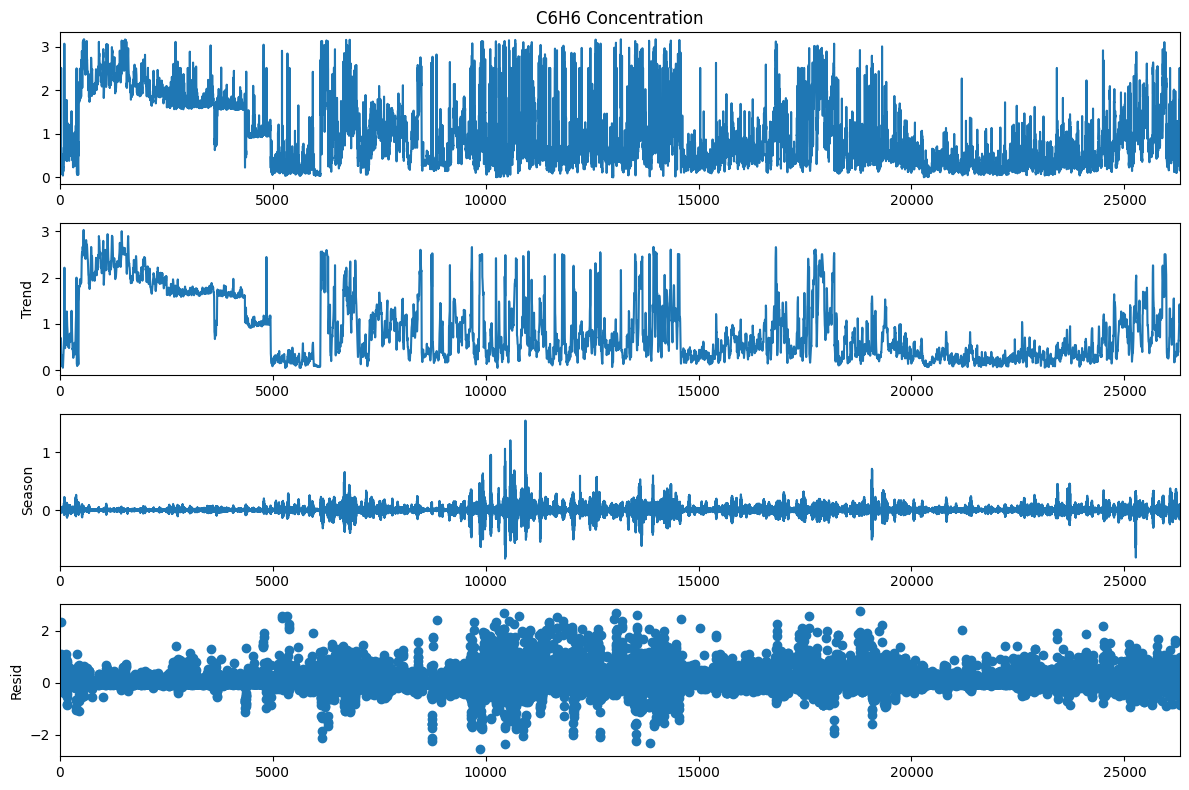

In [69]:
result_c6h6 = STL(df['C6H6 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_c6h6.plot()
# plt.show()

In [70]:
cleaned_training_df = pd.DataFrame({
    'PM10 Concentration': result_pm10.trend,
    'PM2.5 Concentration': result_pm25.trend,
    'CO Concentration': result_co.trend,
    'NO2 Concentration': result_no2.trend,
    'SO2 Concentration': result_so2.trend,
    'C6H6 Concentration': result_c6h6.trend,
})
cleaned_training_df.head()

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration,SO2 Concentration,C6H6 Concentration
0,24.826896,26.019786,0.369785,17.614597,5.211591,0.537017
1,24.825908,25.984320,0.368750,17.588960,5.211224,0.535476
2,24.826556,25.945189,0.367656,17.559050,5.210626,0.533749
3,24.830294,25.903923,0.366464,17.520714,5.209759,0.531888
4,24.839789,25.864980,0.364923,17.467378,5.209020,0.529980


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >], dtype=object)

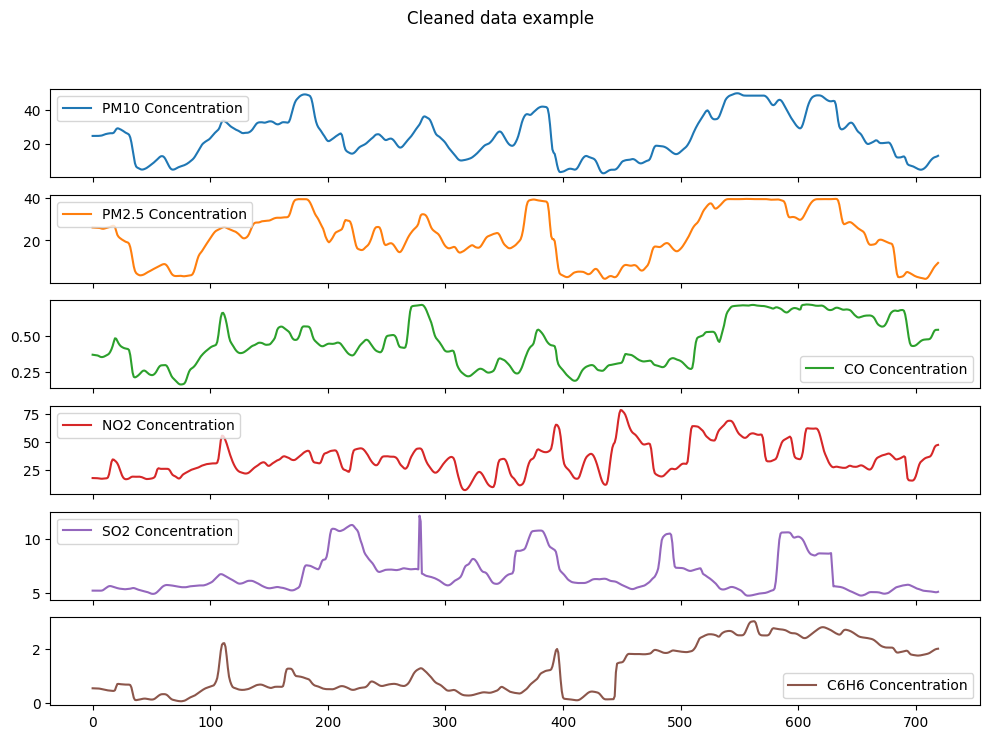

In [71]:
cleaned_training_df[:720].plot(subplots=True, title='Cleaned data example')

## Data scaling

In [72]:
scaler = MinMaxScaler()
df[:] = scaler.fit_transform(df)
cleaned_training_df[:] = scaler.transform(cleaned_training_df)

In [73]:
cleaned_training_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM10 Concentration,26305.0,0.395038,0.208825,0.010171,0.239910,0.363739,0.510696,0.964110
PM2.5 Concentration,26305.0,0.370353,0.241046,0.052869,0.190134,0.296022,0.485874,0.986191
CO Concentration,26305.0,0.442833,0.187462,0.065912,0.305711,0.397557,0.545411,0.968337
NO2 Concentration,26305.0,0.343576,0.203938,0.016748,0.172969,0.311974,0.474979,0.926141
SO2 Concentration,26305.0,0.388862,0.166251,0.038984,0.237632,0.344320,0.536872,0.877885
C6H6 Concentration,26305.0,0.277964,0.218587,0.014420,0.102420,0.195151,0.409211,0.957955


## Data windowing

In [74]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        self.train_set = train_df
        self.val_set = val_df
        self.test_set = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.create_dsets()

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}', f'Input indices: {self.input_indices}', f'Label indices: {self.label_indices}', f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds

    # @property
    def train(self):
        return self.make_dataset(self.train_set)

    # @property
    def val(self):
        return self.make_dataset(self.val_set)

    # @property
    def test(self):
        return self.make_dataset(self.test_set)

    def create_dsets(self):
        self.train = self.train()
        self.val = self.val()
        self.test = self.test()

    @property
    def example(self):
        result = getattr(self, '_example', None)
        result = next(iter(self.test))
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, max_subplots=4, training_data=False):
        inputs, labels = None, None
        if training_data:
            inputs, labels = next(iter(self.train))
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))
        print(len(inputs), len(labels))
        for n in range(max_n):
            plot_col = 'PM10 Concentration'
            if n == 2:
                plot_col = 'PM2.5 Concentration'
            elif n == 3:
                plot_col = 'CO Concentration'
            elif n == 4:
                plot_col = 'NO2 Concentration'
            plot_col_index = self.column_indices[plot_col]
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', zorder=-10, c='#2a7ab8')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            if label_col_index is None:
                continue

            if training_data:
                plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', zorder=-10, c='#42a7f5')
            else:
                plt.plot(self.label_indices, labels[n, :, label_col_index], label='Real Data', zorder=-10, c='#42a7f5')
            if model is not None:
                predictions = model(inputs)
                plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#0eb039')

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        # print(self.label_columns)

In [75]:
df = df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']]
cleaned_training_df = cleaned_training_df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']]

In [103]:
num_features = df.shape[1]
n = len(df)
# train = df[0:int(n*0.7)]
train = cleaned_training_df[0:int(n*0.7)].to_numpy()
val = df[int(n*0.7):int(n*0.9)].to_numpy()
test = df[int(n*0.9):].to_numpy()

# dataWin = WindowGenerator(input_width=5*24, label_width=48, shift=48, train_df=train, val_df=val, test_df=test)

In [111]:
look_back = 20
train_ds = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    train, train, length=look_back, batch_size=1
)
val_ds = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    val, val, length=look_back, batch_size=1
)
test_ds = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    test, test, length=look_back, batch_size=1
)

## Model creation and training

In [117]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(look_back, 4)),
    tf.keras.layers.LSTM(units=4, return_sequences=True, activation='relu'),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='sigmoid')
    # tf.keras.layers.Reshape([num_features, 5])
])
model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 20, 4)             144       
                                                                 
 dense_10 (Dense)            (None, 20, 20)            100       
                                                                 
 dense_11 (Dense)            (None, 20, 4)             84        
                                                                 
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.fit(train_ds, epochs=3)

Epoch 1/3
18393/18393 [==============================] - 81s 4ms/step - loss: 0.0163 - mean_absolute_error: 0.0939 - root_mean_squared_error: 0.1276 - mean_absolute_percentage_error: 28.8358
Epoch 2/3
18393/18393 [==============================] - 75s 4ms/step - loss: 0.0154 - mean_absolute_error: 0.0899 - root_mean_squared_error: 0.1239 - mean_absolute_percentage_error: 27.5320
Epoch 3/3
18393/18393 [==============================] - 77s 4ms/step - loss: 0.0150 - mean_absolute_error: 0.0881 - root_mean_squared_error: 0.1223 - mean_absolute_percentage_error: 26.9198


### Hyperparameter tuning

In [29]:
def modelBuilder(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, input_shape=(5*24, 4), return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=hp.Int('units', min_value=128, max_value=254, step=32), activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=4*48, activation='relu'),
        tf.keras.layers.Reshape([48, num_features])
    ])

    l_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    return model

In [50]:
testModel = tf.keras.Sequential([
    tf.keras.layers.LSTM(72, input_shape=(5*24, 4), return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=254, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=4*48, activation='relu'),
    tf.keras.layers.Reshape([48, num_features])
])

In [51]:
testModel.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanAbsolutePercentageError()
    ]
)

In [52]:
history = testModel.fit(dataWin.train, epochs=20, callbacks=[early_stopping], shuffle=True)

Epoch 1/20
571/571 [==============================] - 28s 46ms/step - loss: 0.0374 - mean_absolute_error: 0.1455 - root_mean_squared_error: 0.1933 - mean_absolute_percentage_error: 44.1164
Epoch 2/20
571/571 [==============================] - 25s 45ms/step - loss: 0.0266 - mean_absolute_error: 0.1236 - root_mean_squared_error: 0.1631 - mean_absolute_percentage_error: 38.8921
Epoch 3/20
571/571 [==============================] - 27s 47ms/step - loss: 0.0237 - mean_absolute_error: 0.1161 - root_mean_squared_error: 0.1539 - mean_absolute_percentage_error: 36.4803
Epoch 4/20
571/571 [==============================] - 26s 46ms/step - loss: 0.0213 - mean_absolute_error: 0.1100 - root_mean_squared_error: 0.1458 - mean_absolute_percentage_error: 34.3496
Epoch 5/20
571/571 [==============================] - 25s 45ms/step - loss: 0.0192 - mean_absolute_error: 0.1046 - root_mean_squared_error: 0.1387 - mean_absolute_percentage_error: 32.4544
Epoch 6/20
571/571 [==============================] - 2

In [30]:
# LSTMmodel = tf.keras.models.Sequential([
#         tf.keras.layers.LSTM(72, activation='relu', input_shape=(5*24, 4), return_sequences=True),
#         # tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Flatten(),
#         # tf.keras.layers.Dropout(0.3),
#         # tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(48, activation='relu'),
#         tf.keras.layers.Reshape([12, num_features])
# ])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

# LSTMmodel.compile(
#         loss=tf.keras.losses.MeanSquaredError(),
#         optimizer=tf.keras.optimizers.Adam(),
#         metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
# )
# LSTMmodel.summary()

tuner = kt.Hyperband(
    modelBuilder,
    objective='loss',
    max_epochs=5,
)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [31]:
tuner.search(dataWin.train, epochs=5, callbacks=[early_stopping])

INFO:tensorflow:Oracle triggered exit


In [63]:
hyper_params = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best earning rate: {hyper_params.get("learning_rate")}       Best dense unit num: {hyper_params.get("units")}')

Best earning rate: 0.001       Best dense unit num: 128


In [64]:
LSTMmodel = tuner.hypermodel.build(hyper_params)
LSTMmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 120, 72)           22176     
                                                                 
 flatten_1 (Flatten)         (None, 8640)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1106048   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 48)                6192      
                                                                 
 reshape_1 (Reshape)         (None, 12, 4)             0         
                                                                 
Total params: 1,134,416
Trainable params: 1,134,416
No

In [65]:
history = LSTMmodel.fit(dataWin.train, epochs=30, callbacks=[early_stopping], shuffle=True)

Epoch 1/5
572/572 [==============================] - 25s 42ms/step - loss: 0.0333 - mean_absolute_error: 0.1324 - root_mean_squared_error: 0.1825 - mean_absolute_percentage_error: 37.4371
Epoch 2/5
572/572 [==============================] - 27s 47ms/step - loss: 0.0161 - mean_absolute_error: 0.0939 - root_mean_squared_error: 0.1267 - mean_absolute_percentage_error: 27.6497
Epoch 3/5
572/572 [==============================] - 25s 43ms/step - loss: 0.0135 - mean_absolute_error: 0.0857 - root_mean_squared_error: 0.1160 - mean_absolute_percentage_error: 25.5191
Epoch 4/5
572/572 [==============================] - 28s 48ms/step - loss: 0.0122 - mean_absolute_error: 0.0815 - root_mean_squared_error: 0.1105 - mean_absolute_percentage_error: 24.3301
Epoch 5/5
572/572 [==============================] - 24s 42ms/step - loss: 0.0115 - mean_absolute_error: 0.0789 - root_mean_squared_error: 0.1071 - mean_absolute_percentage_error: 23.6303


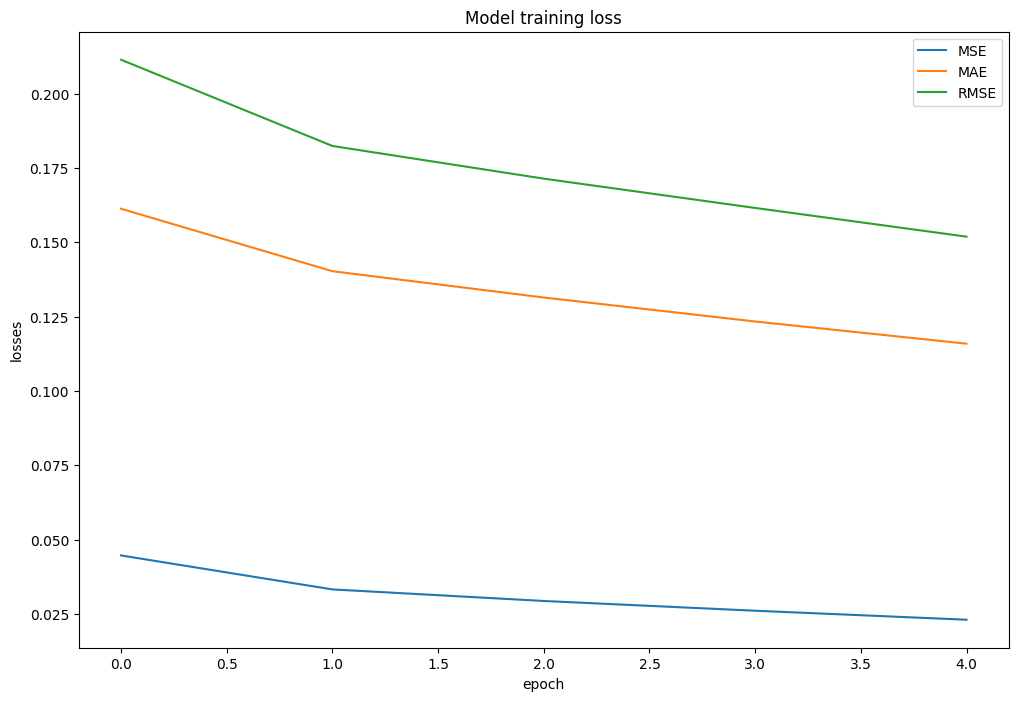

In [47]:
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['mean_absolute_error'], label='MAE')
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Model training loss')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [67]:
eval_score = LSTMmodel.evaluate(dataWin.val)
print(f'MSE, MAE, RMSE, MAPE: {eval_score}')

161/161 [==============================] - 3s 13ms/step - loss: 0.0265 - mean_absolute_error: 0.1197 - root_mean_squared_error: 0.1627 - mean_absolute_percentage_error: 34910.2227
MSE, MAE, RMSE, MAPE: [0.026466306298971176, 0.11969214677810669, 0.16268466413021088, 34910.22265625]


32 32


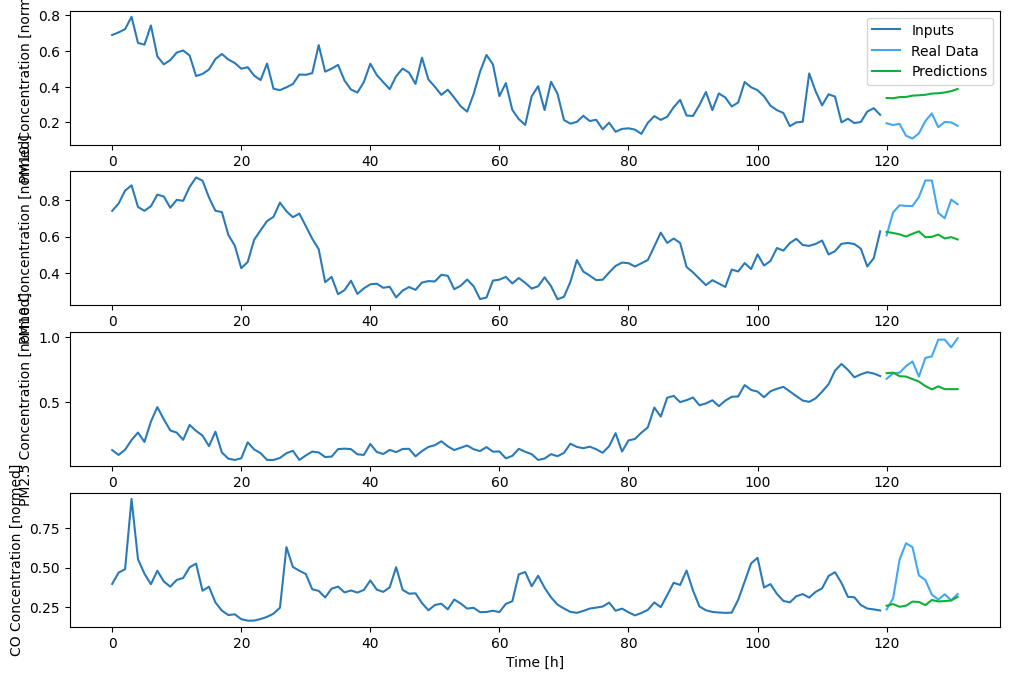

In [68]:
dataWin.plot(LSTMmodel)

32 32


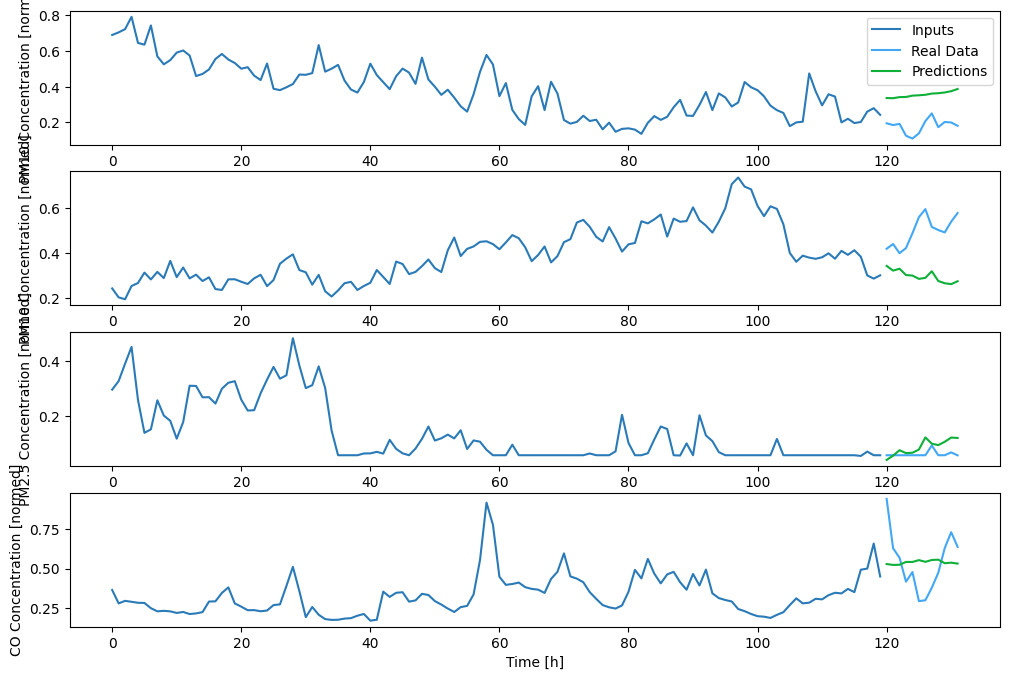

In [69]:
dataWin.plot(LSTMmodel)

32 32


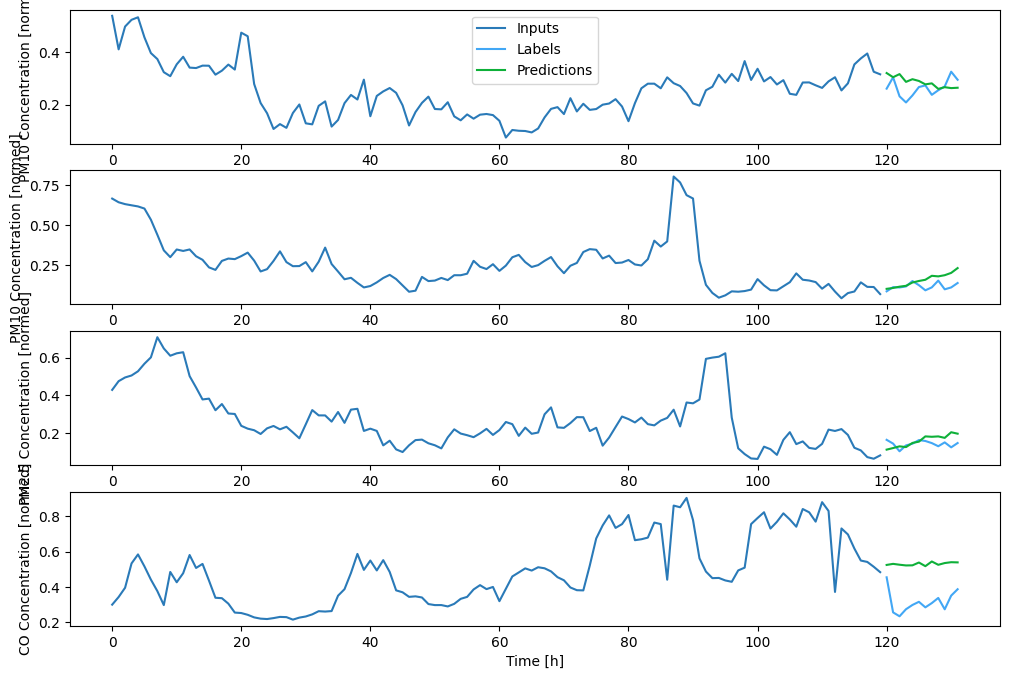

In [70]:
dataWin.plot(LSTMmodel, training_data=True)

32 32


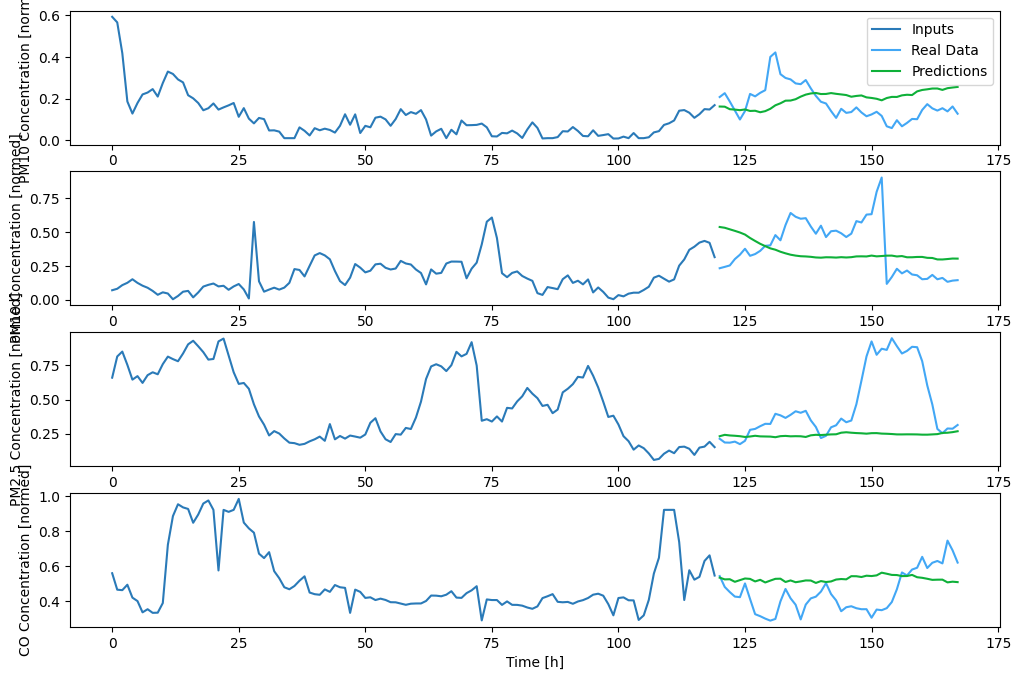

In [53]:
dataWin.plot(testModel)